# Retrievals: Dealing with multiple datasets

Written by [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).
Please cite pRT's retrieval package [(Nasedkin et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024JOSS....9.5875N/abstract) in addition to pRT [(Mollière et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract) if you make use of the retrieval package for your work.

This advanced tutorial will use JWST observations of WASP39 b to demonstrate how to incorporate multiple datasets into the pRT retrieval framework.
This is the nominal `Radtrans` workflow. For the `SpectralModel` workflow, see the [SpectralModel retrieval notebook](./retrieval_spectral_model.ipynb).

## Getting started

**Please make sure to have worked through the ["Basic Retrieval Tutorial"](retrieval_basic.html) before looking at the material below.**

In this tutorial, we will outline the process of setting up a RetrievalConfig object, which is the class used to set up a pRT retrieval.
The basic process is always to set up the configuration, and then pass it to the Retrieval class to run the retrieval using, for example, pyMultiNest.
Like mentioned in the ["Basic Retrieval Tutorial"](retrieval_basic.html) several standard plotting outputs will also be produced by the retrieval class.
Most of the classes and functions used in this tutorial have more advanced features than what will be explained here, so it's highly recommended to take a look at the code and API documentation. 
There should be enough flexibility built in to cover most typical retrieval studies, but if you have feature requests please get in touch, or open an issue on [gitlab](https://gitlab.com/mauricemolli/petitRADTRANS.git).

In [31]:
# Let's start by importing everything we need
import os

import matplotlib.pyplot as plt
import numpy as np

from petitRADTRANS import physical_constants as cst
from petitRADTRANS.radtrans import Radtrans

# Import the class used to set up the retrieval.
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig

# Import Prior functions, if necessary.
from petitRADTRANS.retrieval.utils import gaussian_prior

# Import atmospheric model function
from petitRADTRANS.retrieval.models import guillot_transmission

from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style
set_petitradtrans_plot_style()

Using pRT Plotting style!


Lets start out by setting up a simple run definition.
We'll add the data **after** we define the model function below
Full details of the parameters can be found in the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).

In [4]:
# Lets start out by setting up a simple run definition
# Full details of the parameters can be found in retrieval_config.py

# Since our retrieval has not run yet, we'll set the mode to 'retrieve'.
# If it has already run, we can set it to 'evaluate', so we can make some plots.
# In general, the evaluate functions will also be called after the 'retrieve' mode has finished.

retrieval_config = RetrievalConfig(
    retrieval_name="WASP39b_Guillot_FreeChem_PatchyGreyHaze", 
    run_mode="evaluate", # this must be 'retrieve' to run PyMultiNest, 'evaluate' if looking at an existing run
    pressures=np.logspace(-8,3,100), # Extend up to 10^-8 bar    
    amr=False, # We won't be using adaptive mesh refinement for the pressure grid        
    scattering_in_emission=False
) # This would turn on scattering when calculating emission spectra.
# Scattering is automatically included for transmission spectra.    

## Data
Let's start with reading in the data. The data must be a 1D spectrum with error bars or a covariance matrix.

As in the basic tutorial, we're reading in text files, but this time we also include the column that describes the wavelength bins:
```
# Wavelength [micron], Bins [micron], Flux [W/m2/micron or (Rp/Rstar)^2], Flux Error [W/m2/micron or (Rp/Rstar)^2]
```

As mentioned, the Data class is arguably the most important part of setting up the retrieval.
Not only do you input your data here, but you also choose your model function and resolution. 
This means that you can design a retrieval around different datatypes and retrieve simultaneously on both - for example, if you want the day and nightside of a planet, or want to combine the eastward and westward limbs of a transmission spectrum with different models. 
New in version 3.1: you can now set the `data_resolution` as an array. For many instruments, such as those on JWST, the spectral resolution varies with wavelength. In order to more accurately capture this, you can now pass an array with the spectral resolution at each wavelength, which determines the width of the Gaussian kernel convolved with the model.

You can also set a distance to your object, which will allow you to automatically scale the flux and error of your data using the `scale_to_distance()` method - useful if you have data normalized to 10pc! Finally, there's also a arguments `scale`, `scale_err` and `offset_bool`, which tells the retrieval that the flux or uncertaines should be scaled by an arbitrary multiplicative factor or have an additive offset, both which is set up as a normal retrieval parameter using the `RetrivalConfig.add_parameter()` method. 
The name must be of the format DATANAME_scale_factor or DATANAME_offset. 
This is useful if two datasets are incompatible in absolute photometry, but you still want to use the spectral shape to inform the retrieval.

In this retrieval we're going to include several datasets from different JWST instruments, starting with NIRISS SOSS orders 1 and 2. 
To include both of them , we simply add more than one dataset to our `RetrievalConfig` object. 
Notice that we're also telling the retrieval that we want the data of Order 2 to have an additive offset: this will allow the data to float relative to Order 1, which remains fixed. This can be used to compensate for differences in transit depth between different instruments.

We're also using the built-in `guillot_transmission` model for this retrieval, rather than writing our own model function from scratch.

In [5]:
# Here we import petitRADTRANS to find the path of the example files on your machine.
# In general this is not required, you just put the files in the folder that you are running
# Your script in, for example.
import petitRADTRANS # need to get the name for the example data

path_to_data = "./" 

transmission_directory = "retrievals/transmission/observations/"
retrieval_config.add_data(
    'JWST/NIRISSSOSS/O1',
    f"{path_to_data}{transmission_directory}JWST/WASP39b_NIRISS_SOSS_Order1_R100.dat",
    data_resolution=700,
    model_resolution=400,
    model_generating_function=guillot_transmission,
    external_radtrans_reference=None
)
retrieval_config.add_data(
    'JWST/NIRISSSOSS/O2',
    f"{path_to_data}{transmission_directory}JWST/WASP39b_NIRISS_SOSS_Order2_R100.dat",
    data_resolution=700,
    model_resolution=400,
    offset_bool=True,
    model_generating_function=guillot_transmission,
    external_radtrans_reference=None
)

## External references
Sometimes the datasets will include regions that overlap in wavelength, or where one dataset falls entirely within the wavelength range of another dataset.
In that case we can use an "external reference": for the dataset (let's call it "short") that falls within the wavelength range of the other (let's call it "long") we will not compute a model spectrum.
Instead, we will use the model spectrum calculated for the "long" dataset. This way we only need to compute the spectrum once in the same wavelength range, rather than having the retrieval package initialise two `Radtrans` objects and calculating a spectrum for each. This saves both memory and time. However, be careful here: the model resolution in the reference object should be high enough to properly sample any datasets that reference it!
If you have multiple data sets that do not overlap, but lie back-to-back to each other in wavelength space, with at most small gaps, it makes also sense to use external references, since it reduced computational overheads.

In this example, the NIRSpec PRISM data covers the entire NIRISS SOSS wavelength range, so we can use it as a reference for both NIRISS SOSS orders.

*Note that here we appear to do something odd: the data resolution is more than twice larger than the model resolution for NIRISS SOSS. In the special case here the SOSS data files are binned to R = 100. Thus, while the spectrum was indeed recorded at R=700, it is OK to use a lower pRT model resolution for the retrievals.*

In [6]:
retrieval_config.data = {} # Remove the previous data that was added above to start with a clean slate.
retrieval_config.add_data(
    'JWST/NIRSPEC/PRISM',
    f"{path_to_data}{transmission_directory}JWST/WASP39b_NIRSpec_PRISM_bins_scale1.dat",
    data_resolution=100,
    model_resolution=400,
    offset_bool=True,
    model_generating_function=guillot_transmission
)
retrieval_config.add_data(
    'JWST/NIRISSSOSS/O1',
    f"{path_to_data}{transmission_directory}JWST/WASP39b_NIRISS_SOSS_Order1_R100.dat",
    data_resolution=700,
    model_resolution=400,
    model_generating_function = guillot_transmission,
    external_radtrans_reference='JWST/NIRSPEC/PRISM'  # here we set the external pRT reference to PRISM
)
retrieval_config.add_data(
    'JWST/NIRISSSOSS/O2',
    f"{path_to_data}{transmission_directory}JWST/WASP39b_NIRISS_SOSS_Order2_R100.dat",
    data_resolution=700,
    model_resolution=400,
    offset_bool=True,
    model_generating_function = guillot_transmission,
    external_radtrans_reference = 'JWST/NIRSPEC/PRISM'  # here we set the external pRT reference to PRISM
)

## Model parameters
Here we're using a more complicated atmospheric model to fit the JWST data.
The temperature profile is taken from Guillot 2010, and includes four parameters to describe the shape.
We're freely retrieving the chemical abundances, and include both patchy grey clouds and an enhanced power law slope as a proxy for hazes.
The cloud coverage fraction is set with the `cloud_fraction` (formerly `patchiness`, which will still work) parameter.

If we're using real cloud opacities, rather than grey ones, we, can set the patchiness to only apply to a subset of the cloud species.
To do this, we just need to create a parameter called `complete_coverage_clouds`, and set the `value` to a list of the cloud species that are NOT patchy.

In [7]:
# WASP 39 parameters
retrieval_config.add_parameter(
    name='stellar_radius',
    free=False, 
    value=0.9324 * cst.r_sun
)

# Fix the reference pressure in bar
retrieval_config.add_parameter(
    'reference_pressure',
    False,
    value=0.01
)

# Choose two of log_g, radius and mass priors
retrieval_config.add_parameter(
    'log_g',
    True,
    transform_prior_cube_coordinate=lambda x: 2.0 + 3.5 * x
)
retrieval_config.add_parameter(
    'planet_radius', 
    True,
    transform_prior_cube_coordinate=lambda x: 0.8 * cst.r_jup_mean + (x * 0.8 * cst.r_jup_mean)
)

# Priors for Guillot 2010 Temperature Profile
retrieval_config.add_parameter(
    "T_int", 
    True,
    transform_prior_cube_coordinate=lambda x: 100 + 3500 * x
)
retrieval_config.add_parameter(
    "T_equ",
    True,
    transform_prior_cube_coordinate=lambda x: 100 + 3500 * x
)
retrieval_config.add_parameter(
    "gamma",
    True,
    transform_prior_cube_coordinate=lambda x:  10 ** (-(x / 2) ** 2 / 2)
)
retrieval_config.add_parameter(
    "log_kappa_IR",
    True,
    transform_prior_cube_coordinate=lambda x: -4.0 + 6.0 * x
)

# Grey cloud top pressure
retrieval_config.add_parameter(
    'log_Pcloud',
    True,
    transform_prior_cube_coordinate=lambda x: -8 + 11 * x
)

# Enhanced haze scattering slope  
# kappa                          
retrieval_config.add_parameter(
    'haze_factor',
    True,
    transform_prior_cube_coordinate=lambda x: -4 + 14 * x
)
# gamma
retrieval_config.add_parameter(
    'power_law_opacity_350nm',
    True,
    transform_prior_cube_coordinate=lambda x: 10**(-20 + 40 * x)
)
retrieval_config.add_parameter(
    'power_law_opacity_coefficient',
    True,
    transform_prior_cube_coordinate=lambda x: -20 + 22 * x
)
# Cloud fraction                            
retrieval_config.add_parameter(
    'cloud_fraction',
    True,
    transform_prior_cube_coordinate=lambda x: x
)

# Data offsets
retrieval_config.add_parameter(
    'JWST/NIRSPEC/PRISM_offset',
    True,
    transform_prior_cube_coordinate=lambda x : gaussian_prior(x, 0, 1e-4)
)
retrieval_config.add_parameter(
    'JWST/NIRISSSOSS/O2_offset',
    True,
    transform_prior_cube_coordinate=lambda x : gaussian_prior(x, 0, 1e-4)
)

## Opacities

In [8]:
retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(['H2--H2', 'H2--He'])

# Here we setup the line species for a free retrieval,
# setting the prior bounds of the log10 abundance with the abund_lim parameter
# So the retrieved value is the log mass fraction.
retrieval_config.set_line_species(["H2O__POKAZATEL", "CO-NatAbund", "CO2", "CH4__MM", "SO2"], eq=False, abund_lim = (-8.0,0.0))

## Plotting

Please see  ["Basic Retrieval Tutorial"](retrieval_basic.html) if you do not know what's happening here.

In [9]:
# If in doubt, define all of the plot_kwargs used here.
# Define axis properties of spectral plot if run_mode == 'evaluate'
retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 10

# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
retrieval_config.plot_kwargs["take_PTs_from"] = 'JWST/NIRSPEC/PRISM' 
retrieval_config.plot_kwargs["temp_limits"] = [150, 3000]
retrieval_config.plot_kwargs["press_limits"] = [1e1, 1e-7]

# Corner plot labels
retrieval_config.parameters['log_g'].plot_in_corner = True
retrieval_config.parameters['log_g'].corner_label = r"$\log g$"
retrieval_config.parameters['planet_radius'].plot_in_corner = True
retrieval_config.parameters['planet_radius'].corner_label = r"R$_{pl}$"
retrieval_config.parameters['planet_radius'].corner_transform = lambda x : x/cst.r_jup_mean
retrieval_config.parameters['T_int'].plot_in_corner = True
retrieval_config.parameters['T_int'].corner_label = r"T$_{int}$"
retrieval_config.parameters['T_equ'].plot_in_corner = True
retrieval_config.parameters['T_equ'].corner_label = r"T$_{equ}$"
retrieval_config.parameters['gamma'].plot_in_corner = True
retrieval_config.parameters['gamma'].corner_label = r"$\gamma$"
retrieval_config.parameters['log_kappa_IR'].plot_in_corner = True
retrieval_config.parameters['log_kappa_IR'].corner_label = r"$\log\kappa_{IR}$"
retrieval_config.parameters['log_Pcloud'].plot_in_corner = True
retrieval_config.parameters['log_Pcloud'].corner_label = r"$\log P_{cl}$"
retrieval_config.parameters['haze_factor'].plot_in_corner = True
retrieval_config.parameters['haze_factor'].corner_label = r"$\log\kappa_{haze}$"
retrieval_config.parameters['power_law_opacity_350nm'].plot_in_corner = True
retrieval_config.parameters['power_law_opacity_350nm'].corner_label = r"$\log\gamma_{350nm}$"
retrieval_config.parameters['power_law_opacity_coefficient'].plot_in_corner = True
retrieval_config.parameters['power_law_opacity_coefficient'].corner_label = r"$\log\gamma_{350nm}$"
retrieval_config.parameters['cloud_fraction'].plot_in_corner = True
retrieval_config.parameters['cloud_fraction'].corner_label = r"$f_{cloud}$"
retrieval_config.parameters['JWST/NIRSPEC/PRISM_offset'].plot_in_corner = True
retrieval_config.parameters['JWST/NIRSPEC/PRISM_offset'].corner_label = r"PRISM offset"
retrieval_config.parameters['JWST/NIRISSSOSS/O2_offset'].plot_in_corner = True
retrieval_config.parameters['JWST/NIRISSSOSS/O2_offset'].corner_label = r"SOSS O2 offset"
retrieval_config.parameters['H2O__POKAZATEL'].plot_in_corner = True
retrieval_config.parameters['H2O__POKAZATEL'].corner_label = r"$\log$ H$_{2}$O"
retrieval_config.parameters['CO-NatAbund'].plot_in_corner = True
retrieval_config.parameters['CO-NatAbund'].corner_label = r"$\log$ CO"
retrieval_config.parameters['CO2'].plot_in_corner = True
retrieval_config.parameters['CO2'].corner_label = r"$\log$ CO$_{2}$"
retrieval_config.parameters['CH4__MM'].plot_in_corner = True
retrieval_config.parameters['CH4__MM'].corner_label = r"$\log$ CH$_{4}$"
retrieval_config.parameters['SO2'].plot_in_corner = True
retrieval_config.parameters['SO2'].corner_label = r"$\log$ SO$_{2}$"

## Running the retrieval

Like in ["Basic Retrieval Tutorial"](retrieval_basic.html) we can now run the retrieval.
Most of the various parameters used to control pyMultiNest or Ultranest can be set in the `retrieval.run()` function, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/retrieval/index.html).

Once the retrieval is complete, we can use the `plot_all` function to generate plots of the best fit spectrum, the pressure-temperature profile and the corner plots, also see ["Basic Retrieval Tutorial"](retrieval_basic.html).

In [10]:
output_dir = f"retrievals/transmission/runs/"

retrieval = Retrieval(
    retrieval_config,
    output_directory=output_dir,
    evaluate_sample_spectra=False,  # output the spectrum from nsample random samples.                     
    use_prt_plot_style=True,  # we think that our plots look nice.
    ultranest=False  # let's use pyMultiNest rather than Ultranest
)

Setting up Radtrans object for data 'JWST/NIRSPEC/PRISM'...
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R400_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4__MM.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__MM.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done

This retrieval is very complex and thus takes several days to run with an appropriate number of live points, using hundred of cores on a cluster.

To try to run the retrieval anyway, set `run_retrieval` below to `True`, then execute the cells below.

In [12]:
run_retrieval = True

In [13]:
if run_retrieval:
    # For a test retrieval, so that we can generate plots we'll use only 40 live points and 
    # constant efficiency mode. 
    retrieval.run(
        sampling_efficiency=0.05,
        const_efficiency_mode=True,
        n_live_points=400,
        resume=True
        # See API or other tutorials for additional PyMultiNest or Ultranest parameters
    )

Starting retrieval WASP39b_Guillot_FreeChem_PatchyGreyHaze
Testing data 'JWST/NIRSPEC/PRISM':
 wavelengths:
  OK (no NaN, infinite, or negative value detected)
 spectrum:
  OK (no NaN, infinite, or negative value detected)
 uncertainties:
  OK (no NaN, infinite, or negative value detected)
Testing data 'JWST/NIRISSSOSS/O1':
 wavelengths:
  OK (no NaN, infinite, or negative value detected)
 spectrum:
  OK (no NaN, infinite, or negative value detected)
 uncertainties:
  OK (no NaN, infinite, or negative value detected)
Testing data 'JWST/NIRISSSOSS/O2':
 wavelengths:
  OK (no NaN, infinite, or negative value detected)
 spectrum:
  OK (no NaN, infinite, or negative value detected)
 uncertainties:
  OK (no NaN, infinite, or negative value detected)
Testing model function for data 'JWST/NIRSPEC/PRISM'...
Testing model function for data 'JWST/NIRISSSOSS/O1'...
Testing model function for data 'JWST/NIRISSSOSS/O2'...
No errors detected in the model functions!
  analysing data from retrievals/t

Best fit parameters
Best fit likelihood = -770231694.27
log_g 2.354416972594087
planet_radius 8706099313.006742
T_int 705.405283282178
T_equ 786.0513004107252
gamma 0.8155227824084861
log_kappa_IR -0.37168537781561994
log_Pcloud -3.952594164327733
haze_factor 4.403575509599417
power_law_opacity_350nm 0.4240561586718332
power_law_opacity_coefficient -2.9644367383162766
cloud_fraction 0.881688696927355
JWST/NIRSPEC/PRISM_offset 3.1654358948166856e-05
JWST/NIRISSSOSS/O2_offset -0.00015397035041856856
H2O__POKAZATEL -2.1021479178426192
CO-NatAbund -1.4491062846196119
CO2 -3.7148346925504496
CH4__MM -5.519332052275939
SO2 -3.7443904309664813

Plotting Best-fit spectrum
Best fit likelihood = -770231694.27
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of s

/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:4514: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Plotting PT profiles

Making corner plot

Plotting Abundances profiles
Best fit likelihood = -770231694.27
Finished generating all plots!


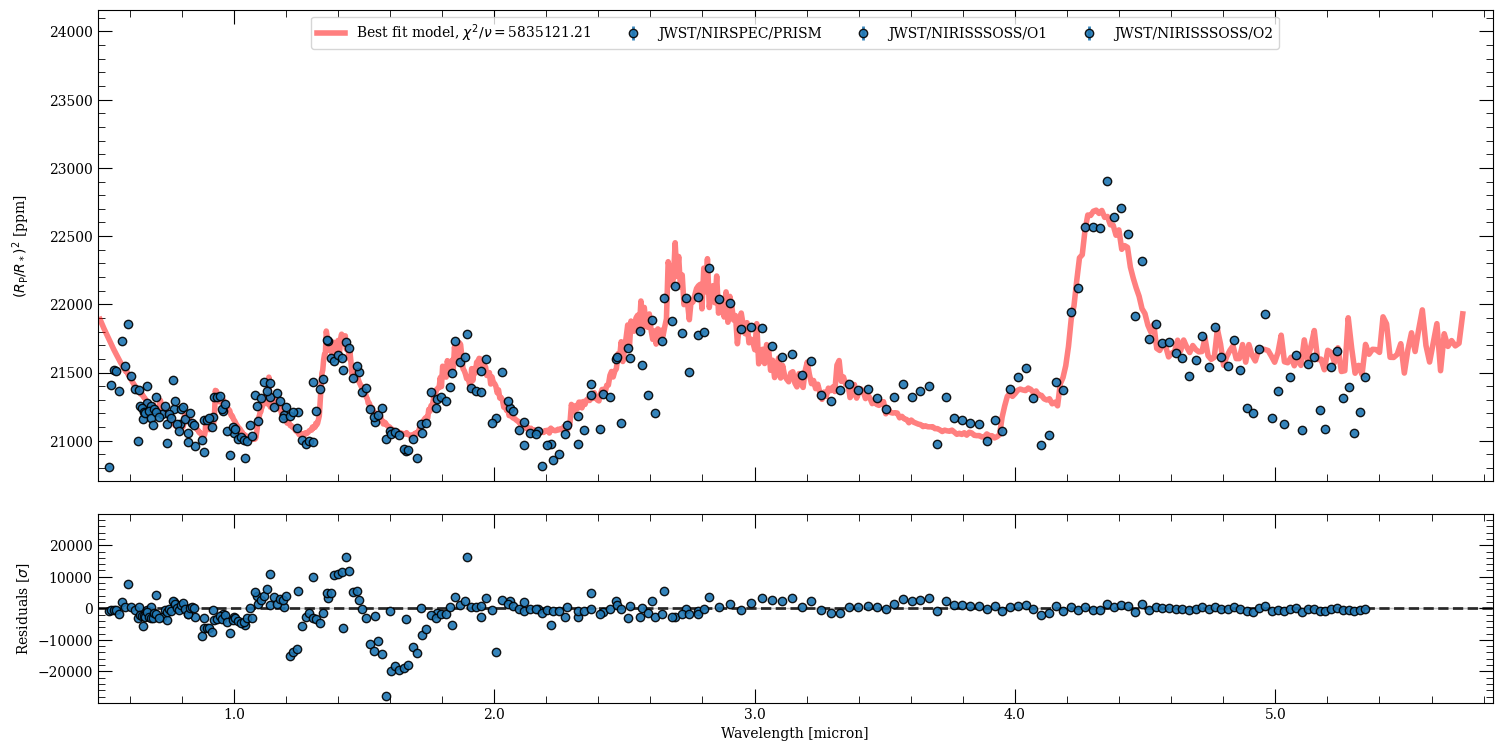

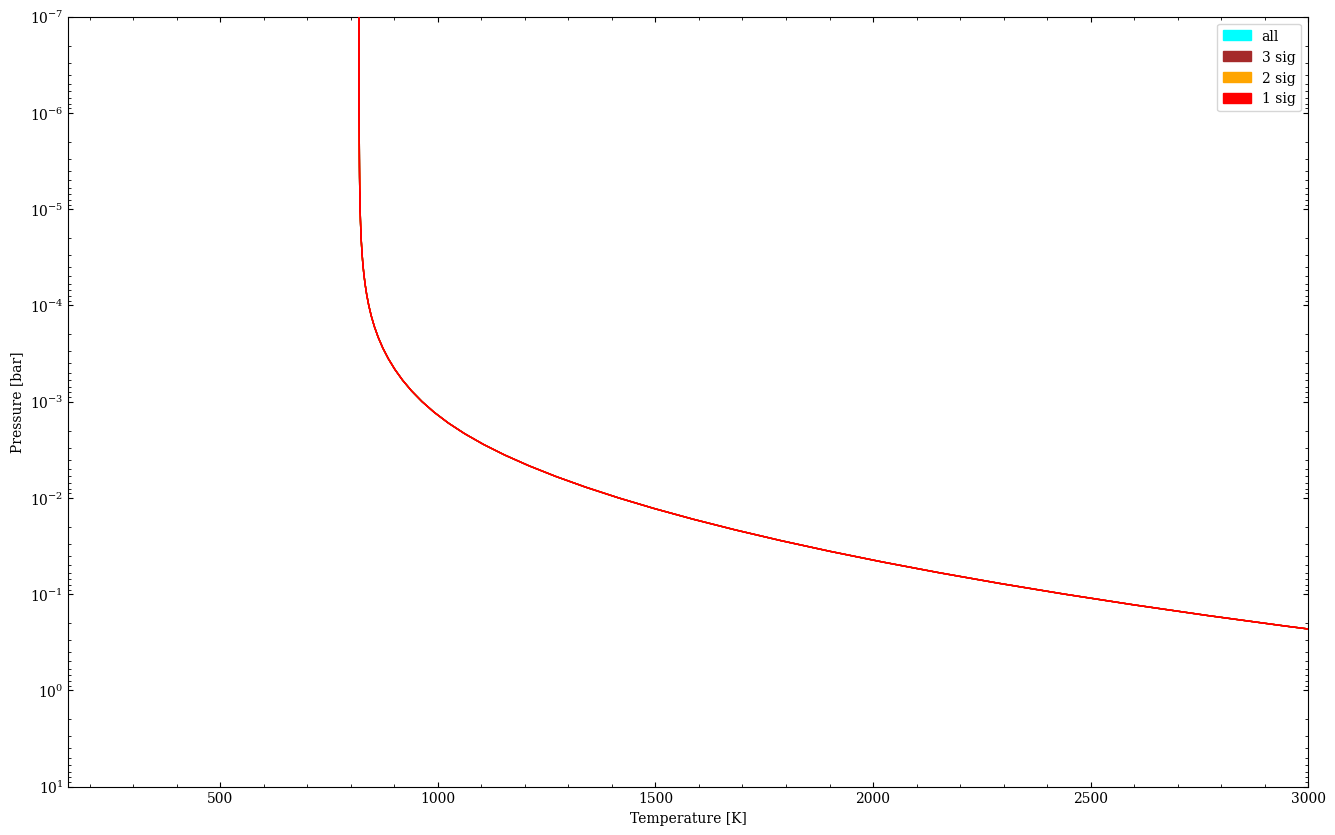

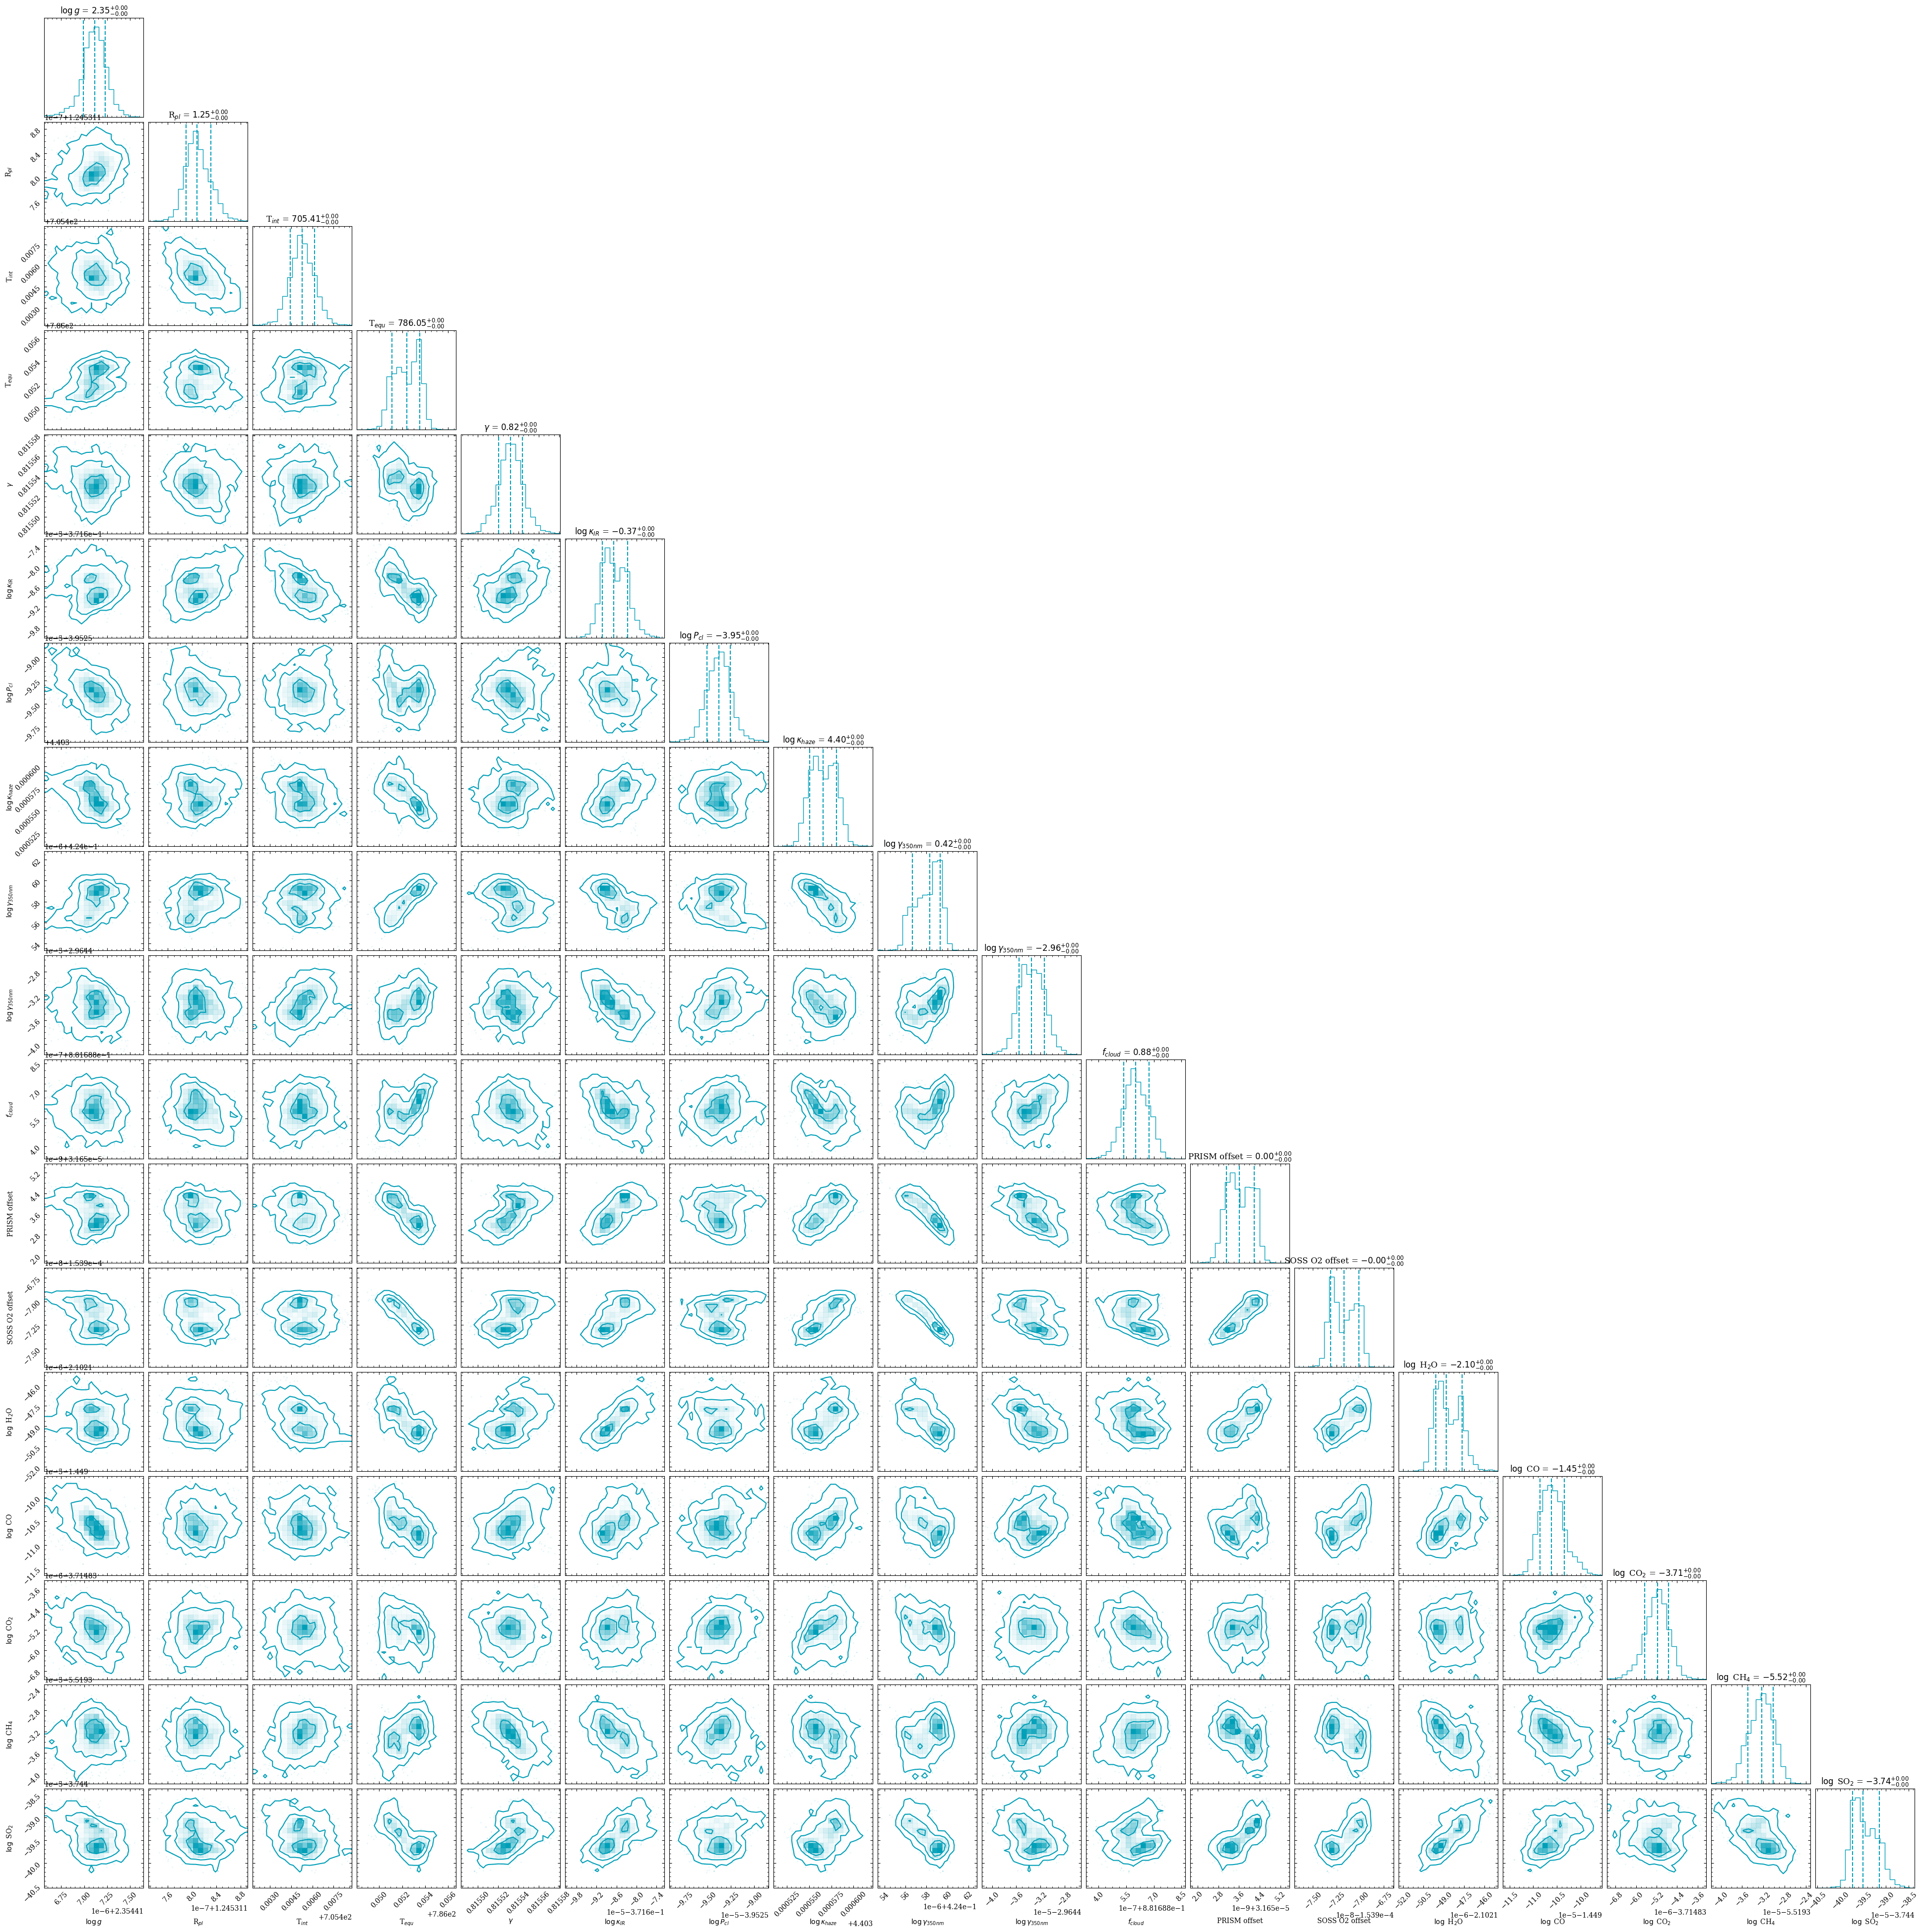

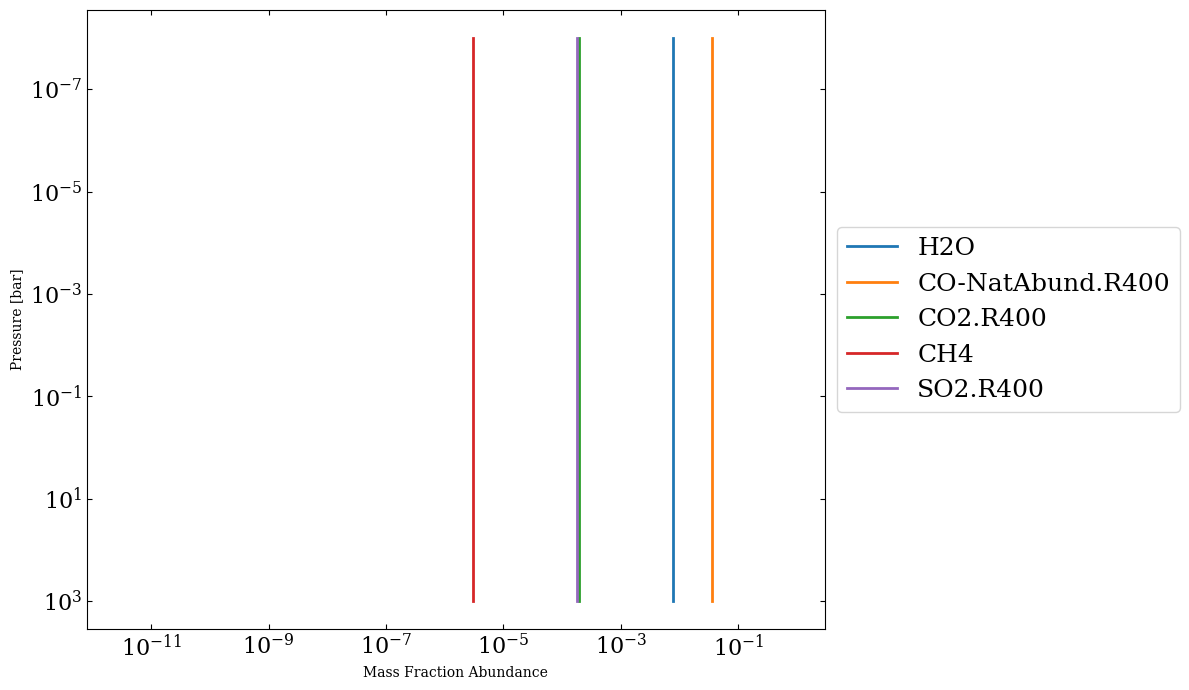

In [27]:
# Automatically generate all of the standard output plots. The contribution 
# argument means that the PT profile and abundance profile plots will display 
# the contribution function. The mode argument means we'll be plotting a model
# based on the median retrieved parameter values, rather than the minimum likelihood
# model.
if run_retrieval:
    retrieval.plot_all(contribution=False, mode='bestfit')
plt.show()

## Post processing
Let's go a bit deeper into analysing the results of a retrieval. We'll start by loading the data in a couple of different ways. The built-in `get_samples` method can take a list of retrieval names as an argument, allowing us to easily compare several retrievals at once.
For a single retrieval, we can also use pandas to load the posterior file, which allows us to easily explore the posterior distributions.

In [24]:
# Load the data
import copy as cp
import pandas as pd

sample_dict, parameter_dict = retrieval.get_samples(ultranest = False, output_directory = retrieval.output_directory)
samples_use = cp.copy(sample_dict[retrieval.configuration.retrieval_name])

parameters_read = parameter_dict[retrieval.configuration.retrieval_name]
columns = cp.copy(parameters_read)
columns.append("log likelihood")

sample_df = pd.read_csv(
    f"{output_dir}out_PMN/{retrieval.configuration.retrieval_name}_post_equal_weights.dat",
    delim_whitespace=True,
    index_col=False,
    names=columns)


/var/folders/66/46srd8053z5_wmg1tlyv021c0000gn/T/ipykernel_13354/2690881040.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sample_df = pd.read_csv(


Let's start out by looking at the best fit results. We can access both the best fit model, and the parameters used to calculate it.

In [25]:
log_l, best_fit_index = retrieval.get_best_fit_likelihood(samples_use)
best_fit_wavelengths, best_fit_spectrum = retrieval.get_best_fit_model(sample_dict[retrieval.configuration.retrieval_name][:-1,best_fit_index],
                                                                        parameters_read,
                                                                        prt_reference=None,
                                                                        refresh=True,
                                                                        contribution=False,
                                                                        mode='bestfit')


Best fit likelihood = -770231694.27
Loading Radtrans opacities...
 Loading line opacities of species 'H2O__POKAZATEL.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R400_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4__MM.R400' from file '/Users/nasedkin/python-packages/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__MM.R400_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacitie

In [77]:
# What are the values of the best fit parameters?
best_fit_parameters = retrieval.best_fit_parameters
for key, param in best_fit_parameters.items():
    print(key, f"{param.value:.2f}")



pressure_scaling 1.00
pressure_width 1.00
pressure_simple 100.00
stellar_radius 64867068000.00
reference_pressure 0.01
log_g 2.35
planet_radius 8706099313.01
T_int 705.41
T_equ 786.05
gamma 0.82
log_kappa_IR -0.37
log_Pcloud -3.95
haze_factor 4.40
power_law_opacity_350nm 0.42
power_law_opacity_coefficient -2.96
cloud_fraction 0.88
JWST/NIRSPEC/PRISM_offset 0.00
JWST/NIRISSSOSS/O2_offset -0.00
H2O__POKAZATEL -2.10
CO-NatAbund -1.45
CO2 -3.71
CH4__MM -5.52
SO2 -3.74
contribution 0.00


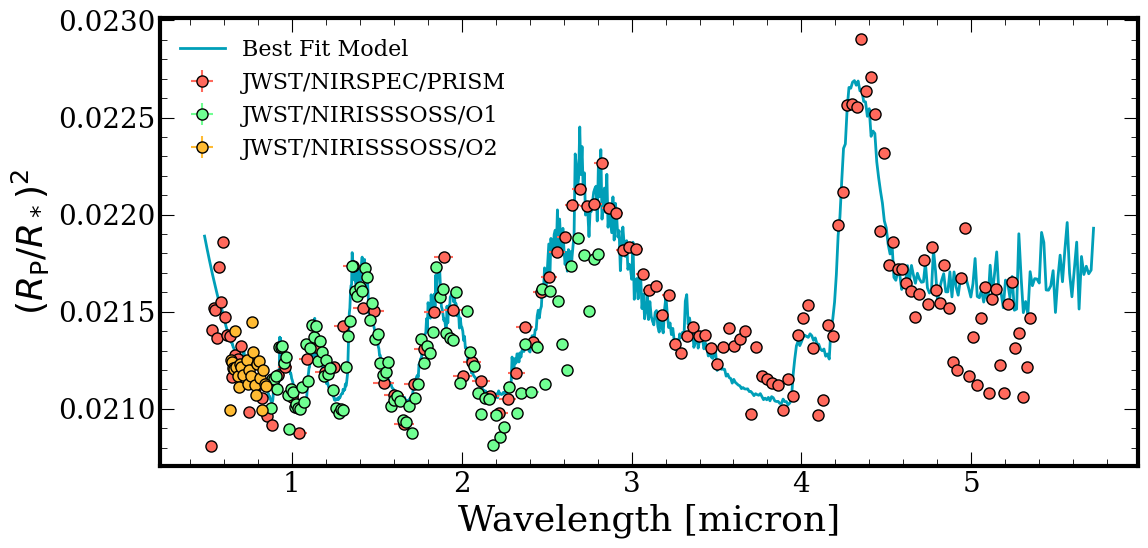

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(best_fit_wavelengths, best_fit_spectrum, label = "Best Fit Model", linewidth = 2)
for name, data in retrieval.configuration.data.items():
    ax.errorbar(data.wavelengths, data.spectrum-data.offset, yerr=data.uncertainties, xerr=data.wavelength_bin_widths, fmt='o', label=name)

ax.set_xlabel("Wavelength [micron]")
ax.set_ylabel(r"$(R_{\rm P}/R_*)^2$")
ax.legend(fontsize=16,frameon=False)
plt.show()

We can also get the convolved model for each instrument, which allows us to directly compare the model and the data.

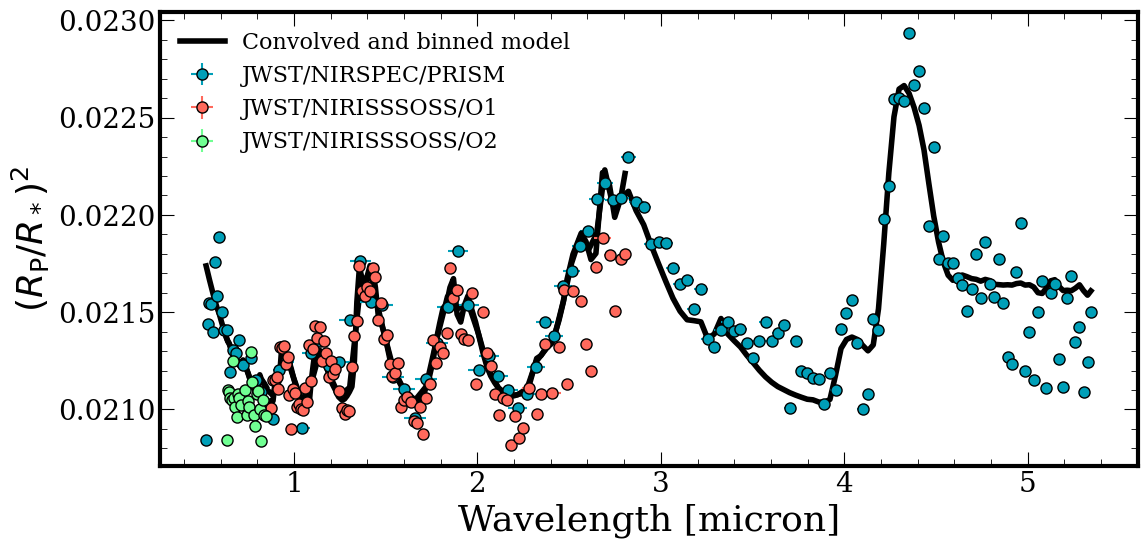

In [40]:
fig, ax = plt.subplots(figsize=(12,6))
for name, data in retrieval.configuration.data.items():
    label = None
    if name == retrieval.configuration.plot_kwargs["take_PTs_from"]:
        label = 'Convolved and binned model'
    ax.plot(retrieval.best_fit_spectra[name][0],retrieval.best_fit_spectra[name][1],label = label, color='k',linewidth=4)
    ax.errorbar(data.wavelengths, data.spectrum, yerr=data.uncertainties, xerr=data.wavelength_bin_widths, fmt='o', label=name)

ax.set_xlabel("Wavelength [micron]")
ax.set_ylabel(r"$(R_{\rm P}/R_*)^2$")
ax.legend(fontsize=16,frameon=False)
plt.show()

We can do the same, but for the temperature profile.

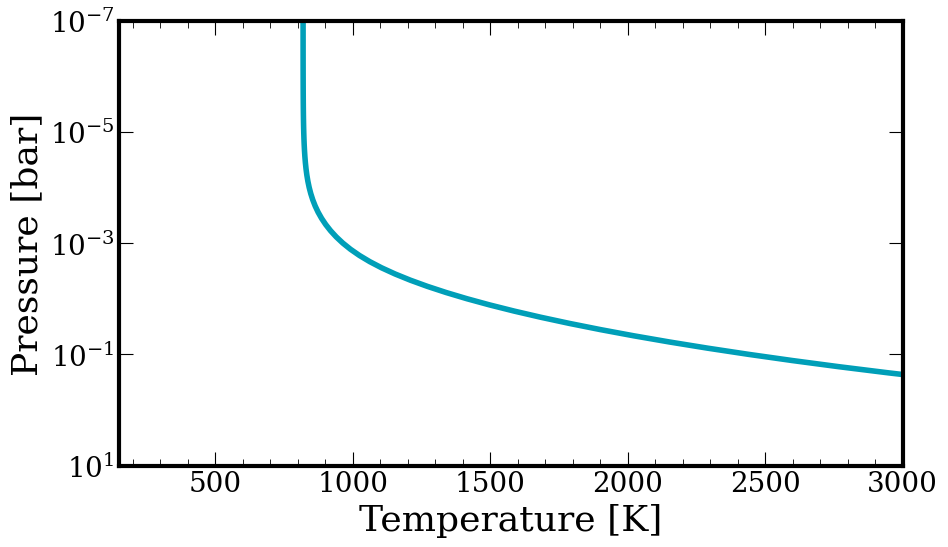

In [44]:
data_to_use = retrieval.configuration.data["JWST/NIRSPEC/PRISM"]
best_fit_parameters = retrieval.best_fit_parameters

best_fit_pressure, best_fit_temperature = data_to_use.model_generating_function(
    data_to_use.radtrans_object, 
    best_fit_parameters, 
    amr=retrieval.configuration.amr,
    pt_plot_mode=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(best_fit_temperature, best_fit_pressure, linewidth=4)
ax.set_yscale('log')
ax.set_ylim(1e1, 1e-7)
ax.set_xlim(150, 3000)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bar]')
plt.show()

We can also load the saved pressure and temperature grid to plot the confidence interval about the temperature profile.

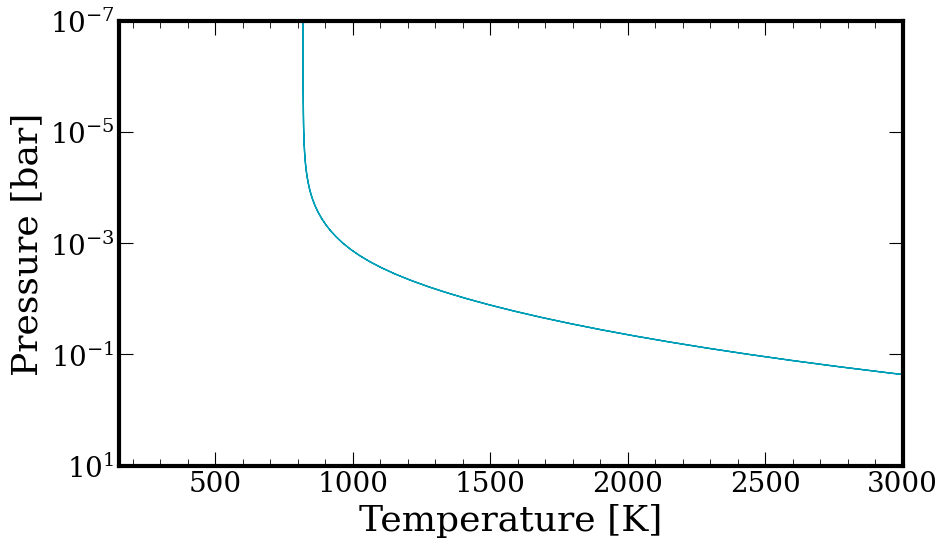

In [82]:
pressures = best_fit_pressure
temperatures = np.load(f"{output_dir}evaluate_{retrieval.configuration.retrieval_name}/{retrieval.configuration.retrieval_name}_temps.npy")
# 99% confidence interval
lower, median, upper = np.quantile(temperatures, [0.005, 0.5, 0.995], axis=0)

fig, ax = plt.subplots(figsize=(10,6))
ax.fill_betweenx(pressures, lower, upper, alpha=1, color = 'C0')

ax.set_yscale('log')
ax.set_ylim(1e1, 1e-7)
ax.set_xlim(150, 3000)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bar]')
plt.show()

There are lots of built in functions to save abundances, models, and even the full retrieval configuration, to ensure consistency if you're moving results from a cluster to your own computer for analysis. 

In [ ]:
# Save the volume mixing ratios for every sample. Only includes gas phase species.
# This can take some time
retrieval.save_volume_mixing_ratios(sample_dict, parameter_dict)

# Save the mass fraction abundances for every species. Includes gas and condensate phase species.
retrieval.save_mass_fractions(sample_dict, parameter_dict)

# Save the best fit spectra
retrieval.save_best_fit_outputs(best_fit_parameters)

# Save the entire retrieval configuration. This will probably be a large file!
retrieval.save_configuration()


We can also get additional outputs, such as the opacities, optical depths, and contribution functions.

In [80]:
from petitRADTRANS.retrieval.parameter import Parameter

data_to_use = retrieval.configuration.data["JWST/NIRSPEC/PRISM"]
press,temps = data_to_use.model_generating_function(data_to_use.radtrans_object,
                                                    retrieval.configuration.parameters,
                                                    amr = retrieval.configuration.amr,
                                                    pt_plot_mode=True)
retrieval.configuration.parameters["return_opacities"] = Parameter("return_opacities",False,True)
retrieval.configuration.parameters["return_cloud_contribution"] = Parameter("return_cloud_contribution",False,True)
retrieval.configuration.parameters["return_optical_depths"] = Parameter("return_optical_depths",False,True)
retrieval.configuration.parameters["return_contribution"] = Parameter("return_contribution",False,True)

wavelength, flux, outputs = data_to_use.model_generating_function(
    data_to_use.radtrans_object,
    retrieval.configuration.parameters,
    amr = retrieval.configuration.amr,
    pt_plot_mode=False)

for key in outputs.keys():
    print(key)


opacities
continuum_opacities_scattering
transmission_contribution


**Contact**

If you need any additional help, don't hesitate to contact [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).